#### Teoría de Circuitos II

# Tarea Semanal 8

#### Por Nahuel Braian Contreras

### Parte I - Ejercicio MAI
Los cáclulos del ejercicios se realizaron en OneNote

In [10]:
from IPython.display import IFrame
IFrame("TS8_MAI.pdf", width=900, height=900)

### Validación Circuital

Simulamos el circuito de la parte I de la TS8, para corrobar que llegamos a algo coherente con lo calculado. Debido al diagrama de polos y zeros calculado, deberiamos obtener una transferencia del tipo Butterworth PasaBajo de 3 Orden.

#### Circuito
<img src="Circuito.png">

#### Analisis en frecuencia
Podemos ver que obtuvimos un filtro butter pasabajo normalizado, tal como habiamos previsto. En la frecuencia de 1 Radian (159 Hz aprox.) tenemos 3db de atenuacion.
<img src="Grafico.png">

### Computacion de la transferencia MAI

A traves de las herramientas de simulacion computacional, podemos calcular la transferencia para verificar que es la misma que encontramos manualmente.

In [11]:
import sympy as sp
from splane import print_latex, calc_MAI_impedance_ij, calc_MAI_vtransf_ij_mn, calc_MAI_ztransf_ij_mn

'''    
Cirucito
        
    0---------YL1---1--YL3---2
                    |       |
                   YC2      G
                    |       |
    3---------------+--------
    
'''    

YL1, YL3, YC2, = sp.symbols('Y_L1 Y_L3 Y_C2', complex=True)
G = sp.symbols('G', real=True, positive=True)

# Armo la MAI
#               Nodos: 0      1        2        3
Ymai = sp.Matrix([  
                    [  YL1 ,     -YL1     ,    0    ,    0   ],
                    [ -YL1 ,  YL1+YC2+YL3 ,  -YL3   ,  -YC2  ],
                    [   0  ,     -YL3     ,  G+YL3  ,   -G   ],
                    [   0  ,     -YC2     ,   -G    ,  G+YC2 ]
                 ])

con_detalles = True

print('Transferencia de tensión:')
Vmai = calc_MAI_vtransf_ij_mn(Ymai, 2, 3, 0, 3, verbose=con_detalles)

Transferencia de tensión:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A pesar del signo, podemos ver que la tranasferencia es la misma que la calculada.

### Parte II - Filtros Digitales
Los cáclulos del ejercicios se realizaron en OneNote

In [12]:
from IPython.display import IFrame
IFrame("TS8_FD.pdf", width=900, height=900)

Debido a que el calculo de los coeficientes esta fuertemente relacionado con la frecuencia de corte y de muestreo, dos parametros que vamos variando en los distintas actividades, decidi realizar todo el calculo numerico en python y no en papel para poder visualizar las conclusiones de manera mas eficiente

#### Punto A 
Tenemos una frecuencia de muestreo de 100Khz, con una frecuencia de corte de 1Khz

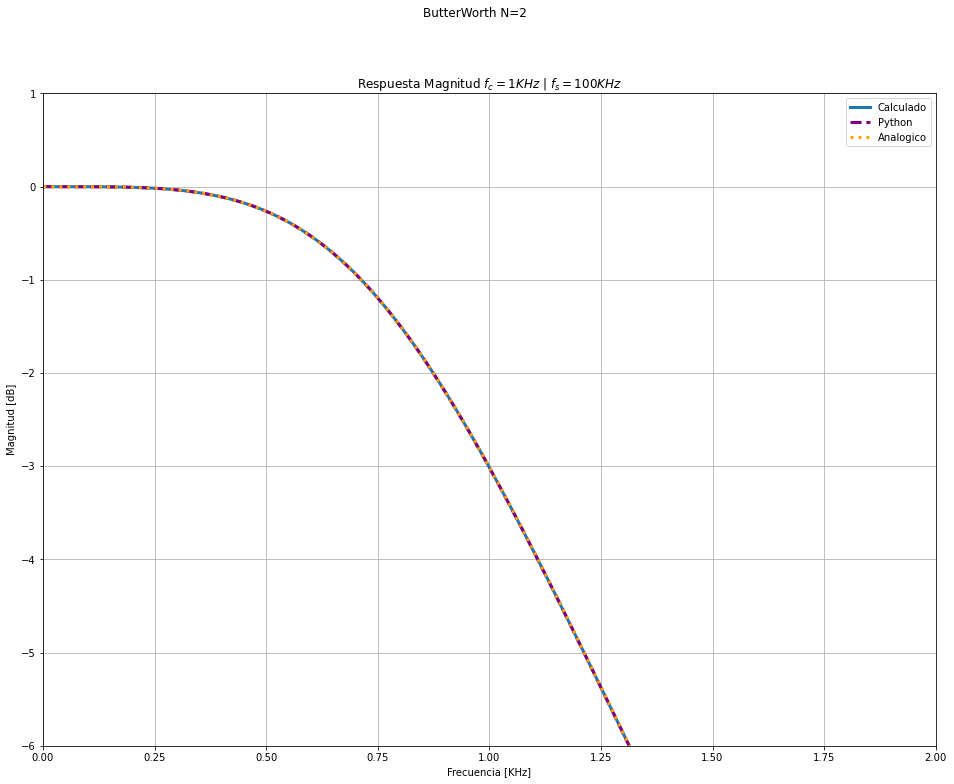

In [13]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

def TS9_funcion(fc, fs,xlim1=0, xlim2=10,ylim1=-60, ylim2=4):
    
    WN = int(5*10e3) # Cantidad de puntos para la funcion Freqz
    KHz = 1000
    # Frecuencia de corte del filtro
    # fc = 1e3
    W_fc = 2*np.pi*fc
    # Frecuencia de Sampling
    # fs = 100e3
    nq = fs/2
    ws = 2*np.pi*fs
    
    # Normalizacion de las Fs
    fs_n = fs/W_fc
    ws_n = ws/W_fc
    
    # K de transormada Bilineal
    K = 2*fs_n
    # Q de Butter Orden 2
    Q = np.sqrt(2)/2
    
    # Coeficientes desnormalizados
    A0 = K**2 + K/Q + 1
    A1 = 2 - 2*K**2
    A2 = K**2 - K/Q + 1
    
    B0 = 1
    B1 = 2
    B2 = 1
    
    #Coeficientes normalizados
    a0 = A0/A0
    a1 = A1/A0
    a2 = A2/A0
    
    b0 = B0/A0
    b1 = B1/A0
    b2 = B2/A0
    
    numz = [b0, b1, b2]
    denz = [a0, a1, a2]
    
    w, h = sig.freqz(numz,denz,WN)
    
    # simulacion python
    num_lp = [0,  0,  1]
    den_lp = [1, 1/Q, 1]
    
    numz_py, denz_py = sig.bilinear(num_lp, den_lp, fs_n) 
    w_py, h_py = sig.freqz(numz_py,denz_py,WN)
    
    # filtro analogico
    # w_analog, h_analog = sig.freqs(num_lp,den_lp)
    w_analog, h_analog = sig.freqs(num_lp,den_lp,  worN=np.logspace(-3, 2, 1000))
    h_analog_db    = 20*np.log10(np.maximum(np.abs(h_analog), 1e-4))
    
    h_db    = 20*np.log10(np.maximum(np.abs(h), 1e-4))
    h_db_py = 20*np.log10(np.maximum(np.abs(h_py), 1e-4))
    
    # Grafico
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    fig.set_size_inches(16,12)
    # MODULO
    fig.suptitle('ButterWorth N=2')
    ax.plot(w*nq/(np.pi*KHz), h_db,linewidth=3, label = 'Calculado')
    ax.plot(w_py*nq/(np.pi*KHz), h_db_py,color='purple',linestyle='dashed',linewidth=3, label = 'Python')
    ax.plot(w_analog*fc/KHz, h_analog_db, color = 'orange',linestyle=':',  linewidth=3, label = 'Analogico')
    ax.grid(True)
    ax.set_title('Respuesta Magnitud $f_c = {:0.0f} KHz$ | $f_s = {:0.0f}KHz$'.format(fc/KHz, fs/KHz))
    ax.set_ylabel('Magnitud [dB]')
    ax.set_xlabel('Frecuencia [KHz]')
    ax.legend()
    ax.set_xlim([xlim1, xlim2])
    ax.set_ylim([ylim1, ylim2])
    
    # # descomentar para ver los graficos en la frecuencia de corte
    
    # # atenuacion 3db en fc = 1KHz
    # ax.set_xlim([0, 2])
    # ax.set_ylim([-14, 3])
    # ax.set_xticks([0, 0.5, 1, 1.5, 2])
    # ax.set_xticklabels(['0', '0.5','$f_c = 1$','1.5','2'])
    # ax.set_yticks([-12, -9, -6, -3, 0, 3])

fc = 1e3
fs = 100e3

TS9_funcion(fc, fs,0,2,-6,1)

Podemos notar que coincide la transferencia calculada "a mano", con la que nos brinda la funcion sig.bilinear. Comparando con la transferencia analogica, vemos que practicamente no hay diferencia entre ellas. Esto se debe a que nuestra frecuencia de corte de 1KHz esta muy lejos de nuestro limite digital, es decir, la frecuencia de Nysquit. Dado que nuestra Fs es de 100KHz, nuestro limite digital se encuentra en Fs/2 (50KHz)

#### Punto B 
Tenemos una frecuencia de muestreo de 10Khz, con una frecuencia de corte de 1Khz

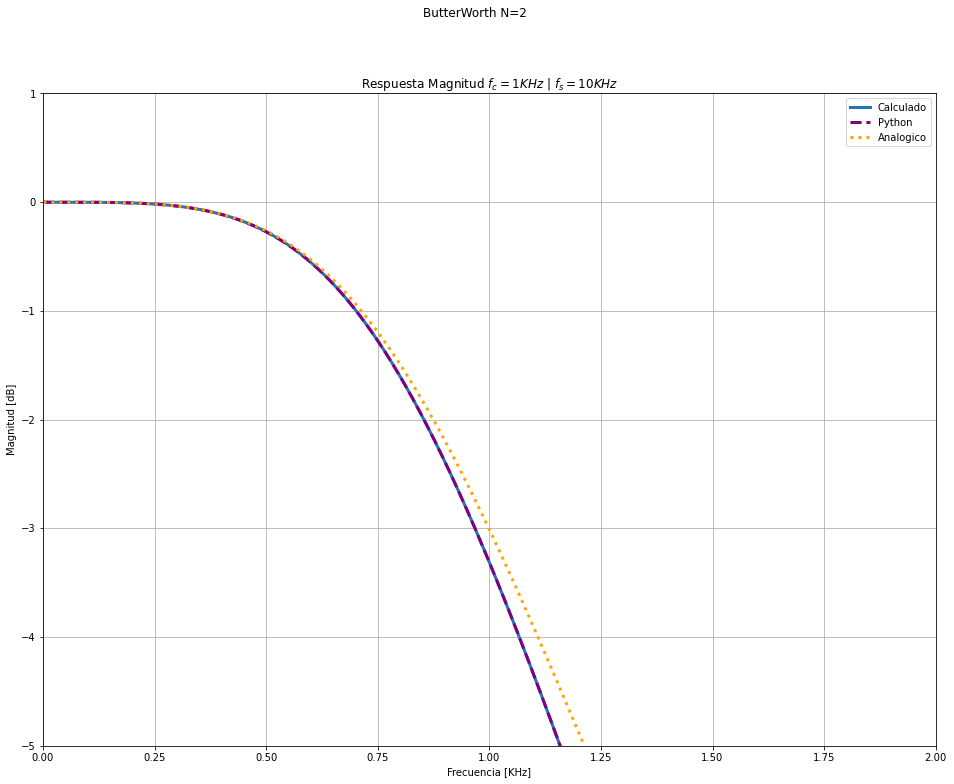

In [14]:
fc = 1e3
fs = 10e3
TS9_funcion(fc, fs,0,2,-5,1)

En este caso, como reducimos la frecuencia de muestreo, podemos notar que existe una leve discrepancia con respecto a la transferencia analógica. No se cumple exactemente lo 3dB de atenuación de Butter en la frecuencia de corte.

#### Punto C
Repetimos los puntos anteriores, pero para una frecuencia de corte de 6KHz.

##### Punto C_A
Usamos una frecuencia de muestreo de 100KHz

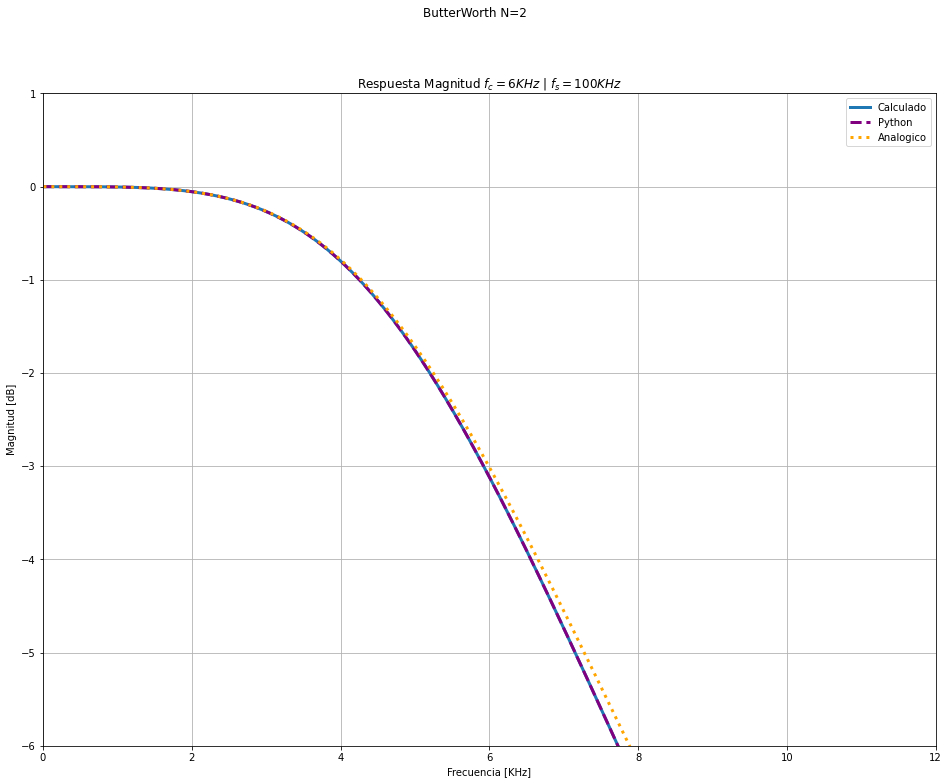

In [15]:
fc = 6e3
fs = 100e3
TS9_funcion(fc, fs,0,12,-6,1)

Volvemos a tener una variación con respecto a la transferencia analógica, pero en menor medida. Esto se debe a que el ratio entre al *frecuencia de muestro y de corte* es **mayor**

##### Punto C_B
Usamos una frecuencia de muestreo de 10KHz

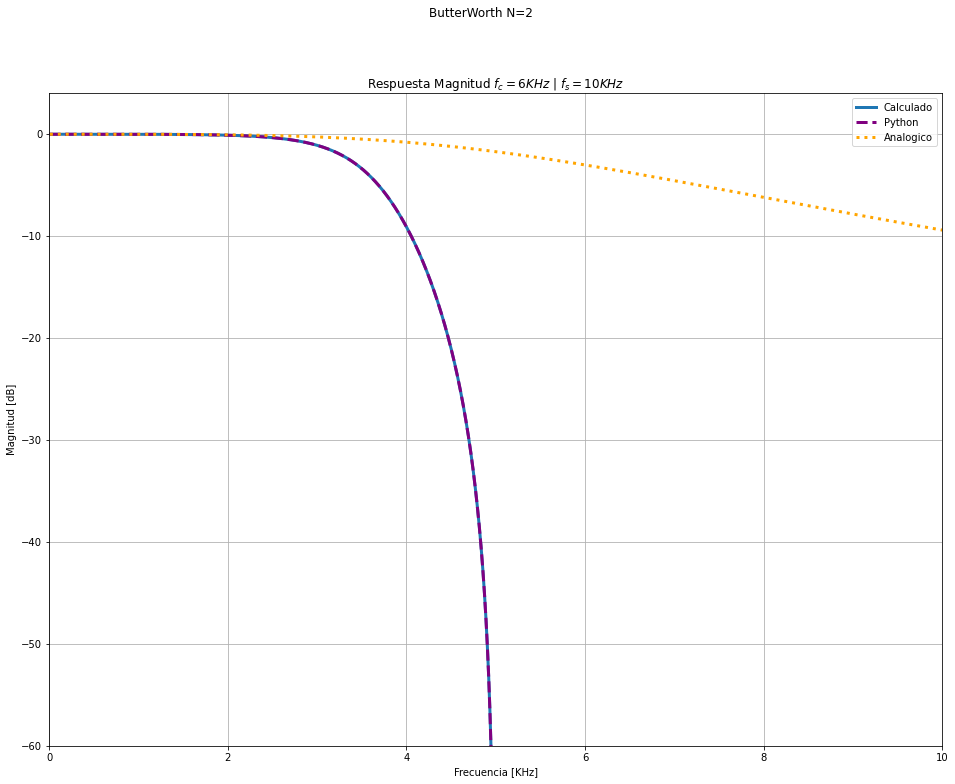

In [16]:
fc = 6e3
fs = 10e3
TS9_funcion(fc, fs)

Al tener una frecuencia de muestro de 10Khz, Nysquit se encuentra en 5KHz. Por lo tanto exedimos nuestro limite digital al querer tener una frecuencia de corte en 6Khz.

#### Punto D
Donde mas se justificaria hacer Prewarping es en el caso B, ya que es donde tenemos el menor de los ratios entre fs/fc. Con el prewarping solucionariamos el error para las frecuencia de interes (Frecuencia de corte)